In [1]:
import pandas
import datetime
import numpy
import scipy.optimize
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
%matplotlib inline
from matplotlib import rcParams

In [2]:
# some constants and cutoffs
mincutOffLosVel = 10.
maxcutOffLosVel = 2500.
mincutOffspWdth = 10.
maxcutOffspWdth = 500.
cellAzmRngCutoff = 40.
cellCntUniqAzimsCutoff = 5.
minCutOffPwr = 3.
cellSizenormMLT = 1.
cellSizeMLAT = 0.5
cutoffAzimStdErr = 100.
cutoffVelStdErr = 25.
cutoffKSPval = 0.1
cutoffKSPAzimStd = 0.9
cutoffKSDstatDMLT = 0.7
cutOffPredWestDelTheta = 25.
cutoffAzmStdLowVal = 5.
minNumPntsCutoffCell = 5 # Somewhat arbitrary determination!!
fitAzmType = "azimCalcMag"
mltFitRange = 1.5

In [3]:
inpCols = [ "beam", "range", "geoAzm", "azimCalcMag", "magAzm", "vLos"\
           , "MLAT", "MLT", "MLON", "GLAT", "GLON", "radId"\
           , "radCode","normMLT", "normMLTRound", "spwdth", "pwr" ]
velsDataDF = pandas.read_csv("../data/test-losVels.txt")#apr9-840-losVels.txt
velsDataDF.columns = inpCols
velsDataDF = velsDataDF[ (abs(velsDataDF["vLos"]) >= mincutOffLosVel) &\
                       (velsDataDF["spwdth"] >= mincutOffspWdth)&\
                       (velsDataDF["pwr"] >= minCutOffPwr)&\
                       (abs(velsDataDF["vLos"]) <= maxcutOffLosVel)&\
                       (velsDataDF["spwdth"] <= maxcutOffspWdth)].reset_index(drop=True)
velsDataDF.head()

,beam,range,geoAzm,azimCalcMag,magAzm,vLos,MLAT,MLT,MLON,GLAT,GLON,radId,radCode,normMLT,normMLTRound,spwdth,pwr
0,0,1,-59.02,-52.7775,-999.0,-64.7805,49.8403,0.1752,-34.8365,39.3801,-101.4120,204,fhw,0.1752,0,11.6335,17.9555
1,0,1,-59.02,-52.7775,-999.0,-64.7805,49.8403,0.1752,-34.8365,39.3801,-101.4120,204,fhw,0.1752,0,11.6335,17.9555
2,0,2,-59.02,-55.7327,-999.0,-66.4007,50.0213,0.1312,-35.4965,39.6422,-101.9031,204,fhw,0.1312,0,12.1331,17.8721
3,0,2,-59.02,-55.7327,-999.0,-66.4007,50.0213,0.1312,-35.4965,39.6422,-101.9031,204,fhw,0.1312,0,12.1331,17.8721
4,0,3,-59.02,-58.1100,-999.0,-71.8733,50.1799,0.0883,-36.1401,39.8805,-102.3838,204,fhw,0.0883,0,12.1331,13.5999


In [4]:
minLat = round( velsDataDF["MLAT"].min() )
maxLat = round( velsDataDF["MLAT"].max() )
minnormMLT = round( velsDataDF["normMLT"].min() )
maxnormMLT = round( velsDataDF["normMLT"].max() )
# Keep lists for storing details later
uniqAzimListMlat = []
uniqAzimListMlt = []
uniqAzimListdelMLT = []
uniqAzimListAzimsUniq = []
uniqAzimListAzimRange = []
# loop through each cell and get an l-shell fit
for la in numpy.arange( minLat, maxLat+1, cellSizeMLAT ):
    for ml in numpy.arange( minnormMLT, maxnormMLT+1, cellSizenormMLT ):
        dfSel = velsDataDF[ (velsDataDF["MLAT"] >= la - cellSizeMLAT/2.) &\
                              (velsDataDF["MLAT"] < la + cellSizeMLAT/2.) ]
        # Since we are working with large MLT ranges (for fitting)
        # It is appropriate to check if there actually are good enough
        # number of data points in the cell ( +/- 0.5 MLT range ). If yes
        # we proceed if not we skip the cell !!
        chkCntDF = dfSel[ abs( dfSel["normMLT"] -ml ) <= 0.5 ]
        if chkCntDF.shape[0] < minNumPntsCutoffCell:
            continue
        # round off azimuths for ease of calc
        dfSel["rndAzim"] = dfSel[fitAzmType].round()
        # get MLTs to nearest half
        dfSel["normMLTRound"] = [ \
                round(x * 2) / 2 for\
                x in dfSel["normMLT"] ]
        mltAzmDF = dfSel.groupby(["normMLTRound"])\
            ["rndAzim"].aggregate(\
                lambda x: tuple(x)).reset_index()
        # get MLTs closest to the current one
        # we'll check the closest MLTs which are
        # 0, 0.5 and 1 MLT. We'll not go beyond 
        # +/- 1. hour in MLT (2 MLT hour range)
        # keep a list of unq azim values at diff
        # del MLT ranges
        fullUniqAzimList = []
        for delMLT in numpy.arange( 0., mltFitRange+0.5, 0.5 ): 
            currAzimValsDF = mltAzmDF[ \
                abs(mltAzmDF["normMLTRound"] - ml) <= delMLT ]#["rndAzim"]
            # Check if there are any values
            if currAzimValsDF.shape[0] == 0:
                continue
            currUniqazimList = list( set( [ j for i in\
                        currAzimValsDF["rndAzim"].tolist()\
                        for j in i ] ) )
            fullUniqAzimList = list( set( fullUniqAzimList + currUniqazimList ) )
            uniqAzimListMlat.append( la )
            uniqAzimListMlt.append( ml )
            uniqAzimListdelMLT.append( delMLT )
            uniqAzimListAzimsUniq.append( fullUniqAzimList )
            uniqAzimListAzimRange.append( \
                    max(fullUniqAzimList) - min(fullUniqAzimList) )
                
# convert to a dataframe
azimCharDF = pandas.DataFrame(
    {'MLAT': uniqAzimListMlat,
     'MLT': uniqAzimListMlt,
     'delMLT': uniqAzimListdelMLT,
     'uniqAzmiList': uniqAzimListAzimsUniq,
     'azimRng': uniqAzimListAzimRange
    })
# In each row get a count of uniqAzims
azimCharDF["countUniqAzims"] = [ len(x) for x in azimCharDF["uniqAzmiList"] ]
azimCharDF.head(100)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,MLAT,MLT,azimRng,delMLT,uniqAzmiList,countUniqAzims
0,50.0,0.0,25.0,0.0,"[-58.0, -56.0, -53.0, -50.0, -46.0, -43.0, -42...",10
1,50.0,0.0,120.0,0.5,"[-30.0, -27.0, -58.0, -56.0, 60.0, -53.0, -50....",17
2,50.0,0.0,120.0,1.0,"[-30.0, -27.0, -58.0, -56.0, -36.0, -53.0, -50...",17
3,50.0,0.0,120.0,1.5,"[-30.0, -27.0, -58.0, -56.0, 60.0, -53.0, -50....",17
4,50.0,1.0,92.0,0.5,"[-30.0, -27.0, 52.0, 54.0, 57.0, 60.0, 62.0]",7
5,50.0,1.0,120.0,1.0,"[-30.0, -27.0, -58.0, -56.0, -36.0, -53.0, -50...",17
6,50.0,1.0,120.0,1.5,"[-30.0, -27.0, -58.0, -56.0, 60.0, -53.0, -50....",17
7,50.5,0.0,26.0,0.0,"[-60.0, -57.0, -55.0, -54.0, -43.0, -40.0, -37...",8
8,50.5,0.0,119.0,0.5,"[59.0, -60.0, -57.0, -55.0, -54.0, -1.0, -7.0,...",16
9,50.5,0.0,119.0,1.0,"[-37.0, -60.0, -57.0, -34.0, -55.0, -54.0, 57....",16


In [5]:
# Some fitting functions
# Fit a sine curve for a given cell
def vel_sine_func(theta, Vmax, delTheta):
    # we are working in degrees but numpy deals with radians
    # convert to radians
    return Vmax * numpy.sin( numpy.deg2rad(theta) +\
                            numpy.deg2rad(delTheta) )

def model_func(theta, Vmax, delTheta):
    vLos = Vmax * numpy.sin( numpy.deg2rad(theta) +\
                            numpy.deg2rad(delTheta) )
    return vLos

initGuess = ( 1000., 10. )

cl, cm, dMlt----> 60.0 0.0 0.5 42
vMax---> 284.810727347 +/- 11.0675648515
delTheta---> -11.5368715405 +/- 1.62509129069
ksDStat, ksPVal---> 0.142857142857 0.751982002214
--------------------------------------------------------------------------


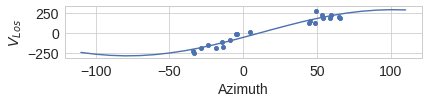

In [14]:
fig = plt.figure()

# Filter out certain unwanted values
azimCharDF = azimCharDF[ (azimCharDF["azimRng"] >= cellAzmRngCutoff) &\
                       (azimCharDF["countUniqAzims"] >= cellCntUniqAzimsCutoff)].reset_index(drop=True)
# Arrays to store results
cellMlatArr = []
cellMLTArr = []
cellVelFitArr = []
cellAzimFitArr = []
cellVelFitStdArr = []
cellAzimFitStdArr = []
cellFitMLTRangeArr = []
cellGoodFitFndArr = []
# get a list of the uniq MLATs and MLTs
# start fitting values to them
for cl, cm in azimCharDF.groupby( [ "MLAT", "MLT" ] ).groups.keys():
    subDF = azimCharDF[ (azimCharDF["MLAT"] == cl) &\
                      (azimCharDF["MLT"] == cm)]
    # Now for each mlat, mlt and delMLT combination
    # fit sine curves and test their goodness of fit
    goodVelStd = None
    goodAzmStd = None
    goodKSDstat = None
    goodKSPval = None
    goodVelFit = None
    goodAzimFit = None
    goodDMLT = None
    for indValDmlt, dMlt in enumerate(subDF["delMLT"].values):
        dfSel = velsDataDF[ (velsDataDF["MLAT"] >= cl - cellSizeMLAT/2.) &\
                          (velsDataDF["MLAT"] < cl + cellSizeMLAT/2.) &\
                        (velsDataDF["normMLT"] >= cm - dMlt) &\
                          (velsDataDF["normMLT"] < cm + dMlt)].reset_index(drop=True)
        if dfSel.shape[0] < minNumPntsCutoffCell:
            continue
        # Need both positive and negative azims for fitting
        # fits without those aren't very good!
        if ( ( dfSel[ dfSel[fitAzmType] > 0. ].shape[0] == 0) or\
            ( dfSel[ dfSel[fitAzmType] < 0. ].shape[0] == 0) ):
            continue
        popt, pcov = scipy.optimize.curve_fit(vel_sine_func, \
                    dfSel[fitAzmType].T,\
                    dfSel['vLos'].T,
                   p0=initGuess)
#         print "vMax--->", popt[0],"+/-", pcov[0,0]**0.5
#         print "delTheta--->", popt[1],"+/-", pcov[1,1]**0.5
        thetaArr = range(-110, 120, 10)
        vLosArr = [ round( model_func(t, popt[0],popt[1]) ) for t in thetaArr ]
        ksTestvLosFitArr = [ round( model_func(t, popt[0],popt[1]) )\
                                for t in dfSel[fitAzmType].tolist() ]
        ksDStat, ksPVal = scipy.stats.ks_2samp( dfSel["vLos"].tolist(),ksTestvLosFitArr )
        if cl == 60. and cm == 0.:
            if dMlt == 0.5:
                figCl = cl
                figCm = cm
                figDmlt = dMlt
                ax = fig.add_subplot(len(subDF["delMLT"].values), 1, indValDmlt+1)
                thetaArr = range(-110, 120, 10)
                vLosArr = [ round( model_func(t, popt[0],popt[1]) ) for t in thetaArr ]
                ax.plot( thetaArr, vLosArr )
                dfSel.plot( x=fitAzmType, y="vLos", kind="scatter", ax=ax )
                print "cl, cm, dMlt---->", cl, cm, dMlt, dfSel.shape[0]
                print "vMax--->", popt[0],"+/-", pcov[0,0]**0.5
                print "delTheta--->", popt[1],"+/-", pcov[1,1]**0.5
                print "ksDStat, ksPVal--->",ksDStat, ksPVal
                print "--------------------------------------------------------------------------"
                ax.set_xlabel("Azimuth", fontsize=14)
                ax.set_ylabel("$V_{Los}$", fontsize=14)
                ax.tick_params(labelsize=14)
#         thetaArr = range(-110, 120, 10)
#         vLosArr = [ round( model_func(t, popt[0],popt[1]) ) for t in thetaArr ]
        
        # Now to store the best fit and discard others
        # To determine it we'll keep only those values
        # with less variance good KS TEST stats.
        percVelStd = abs( (pcov[0,0]**0.5)*100./popt[0] )
        percAzimStd = abs( (pcov[1,1]**0.5)*100./popt[1] )
        # sometimes there are bad fits, we need fits which are
        # predominantly westwards. Discard the rest
        if abs(popt[1]) > cutOffPredWestDelTheta:
            continue
        if percVelStd > cutoffVelStdErr:
            continue
        if percAzimStd > cutoffAzimStdErr:
            # Sometimes there may be decent fits
            # especially if delTheta is low (< 3-4)
            # In that case we can check ksPVal, if it 
            # is greater than say 0.9 we'll keep the fit
            if ksPVal < cutoffKSPAzimStd:
                continue
            else:
                if abs(pcov[1,1]**0.5) >= cutoffAzmStdLowVal:
                    continue
        if ksPVal < cutoffKSPval :
            continue
        if goodVelStd is None:
            # This is the first good fit
            # lets use it for now
            goodVelStd = pcov[0,0]**0.5
            goodAzmStd = pcov[1,1]**0.5
            goodKSDstat = ksDStat
            goodKSPval = ksPVal
            goodVelFit =  popt[0]
            goodAzimFit =  popt[1]
            goodDMLT = dMlt
        else:
            # Now we need to choose one good fit
            # from multiple values.
            # Also we can't choose values with large
            # dMlt span. We'll use ks test D statistic
            # to determine this. If current ks Dstat is 
            # better 30% less than prev best (cutoffKSDstatDMLT=0.7)
            # and std in new is better than prev then use the new one.
            if abs(ksDStat)/abs(goodKSDstat) < cutoffKSDstatDMLT:
                if abs(goodAzmStd/goodAzimFit) > abs(pcov[1,1]**0.5/popt[1]):
                    goodVelStd = pcov[0,0]**0.5
                    goodAzmStd = pcov[1,1]**0.5
                    goodKSDstat = ksDStat
                    goodKSPval = ksPVal
                    goodVelFit =  popt[0]
                    goodAzimFit =  popt[1]
                    goodDMLT = dMlt
    # store results in arr
    if goodVelStd is not None:
        cellMlatArr.append( cl )           
        cellMLTArr.append( cm )
        cellVelFitArr.append( goodVelFit )
        cellAzimFitArr.append( goodAzimFit )
        cellVelFitStdArr.append( goodVelStd )
        cellAzimFitStdArr.append( goodAzmStd )
        cellFitMLTRangeArr.append( goodDMLT )
        cellGoodFitFndArr.append( True )
                
# convert to a dataframe
fitResultsDF = pandas.DataFrame(
    {'mlat': cellMlatArr,
     'normMlt': cellMLTArr,
     'velSAPS': cellVelFitArr,
     'azimSAPS': cellAzimFitArr,
     'velSTD': cellVelFitStdArr,
     'azimSTD': cellAzimFitStdArr,
     'delMLT': cellFitMLTRangeArr,
     'goodFit': cellGoodFitFndArr
    })



fig.savefig("../figs/fits-lshell/fit" + "_" + str(figCl) +\
            "_" + str(figCm) + "_" + str(figDmlt) + ".pdf",\
            bbox_inches='tight')

In [7]:
# Now for plotting purpose calculate end points
fitResultsDF["endPtMLAT"] = numpy.round( (fitResultsDF["velSAPS"]/1000.) *\
                                numpy.cos( numpy.deg2rad(-90-1*fitResultsDF["azimSAPS"]) ) +\
                                fitResultsDF["mlat"], 2)
fitResultsDF["endPtNormMLT"] = numpy.round( (fitResultsDF["velSAPS"]/1000.) *\
                                numpy.sin( numpy.deg2rad(-90-1*fitResultsDF["azimSAPS"]) ) +\
                                fitResultsDF["normMlt"], 2)
print fitResultsDF[ fitResultsDF["normMlt"] == -4 ]

Empty DataFrame
Columns: [azimSAPS, azimSTD, delMLT, goodFit, mlat, normMlt, velSAPS, velSTD, endPtMLAT, endPtNormMLT]
Index: []


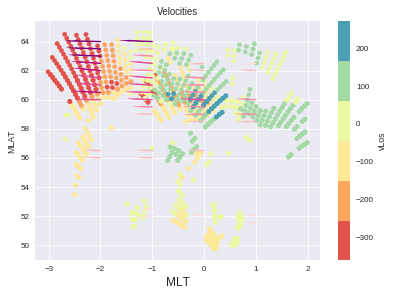

In [8]:
#### Plot the fitted SAPS velocities ####
#### Plot the fitted SAPS velocities ####
#### Plot the fitted SAPS velocities ####
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("RdPu"))
vLosSeaMap = ListedColormap(sns.color_palette("Spectral"))
# Plot using matplotlib
fig1 = plt.figure()
ax = fig1.add_subplot(111)

# fitResultsDF.plot( kind='scatter',
#               x='normMlt',
#               y='mlat',
#               c='velSAPS',
#               s=1., cmap=seaMap, ax=ax)
velsDataDF.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vLos',
              s=20., cmap=vLosSeaMap, ax=ax)
ax.set_ylabel("MLAT")
ax.set_xlabel("MLT", fontsize=12)
ax.set_title( "Velocities" )
# Overlay the SAPS vel vectors
velScaleMin = 0.
# round off max velocity to the next hundred
velScaleMax = (fitResultsDF["velSAPS"].max() + 100.)*100/100 -\
            (fitResultsDF["velSAPS"].max() + 100.)%100
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for frRows in fitResultsDF.iterrows():
    # Plot Velocity vectors
    currCol = seaMap( colNorm(frRows[1]["velSAPS"]) )
    ax.plot( [ frRows[1]["normMlt"] , frRows[1]["endPtNormMLT"] ],\
            [ frRows[1]["mlat"], frRows[1]["endPtMLAT"] ], color=currCol ) 
    ax.arrow( frRows[1]["normMlt"], frRows[1]["mlat"], \
             frRows[1]["endPtNormMLT"]-frRows[1]["normMlt"],\
             frRows[1]["endPtMLAT"]-frRows[1]["mlat"],\
                 head_width=0.1, head_length=0.2, fc=currCol, ec=currCol)
    # Plot boxes to show where fitting data came from
    if ( (frRows[1]["normMlt"] == -5. and frRows[1]["mlat"] == 59.) or\
        (frRows[1]["normMlt"] == -5. and frRows[1]["mlat"] == 63.) ):
        ax.plot( [ frRows[1]["normMlt"] + frRows[1]["delMLT"], frRows[1]["normMlt"] + frRows[1]["delMLT"] ], \
                [ frRows[1]["mlat"] - cellSizeMLAT/2., frRows[1]["mlat"] + cellSizeMLAT/2. ], 'k:' )

        ax.plot( [ frRows[1]["normMlt"] - frRows[1]["delMLT"], frRows[1]["normMlt"] + frRows[1]["delMLT"] ], \
                [ frRows[1]["mlat"] - cellSizeMLAT/2., frRows[1]["mlat"] - cellSizeMLAT/2. ], 'k:' )

        ax.plot( [ frRows[1]["normMlt"] - frRows[1]["delMLT"], frRows[1]["normMlt"] + frRows[1]["delMLT"] ], \
                [ frRows[1]["mlat"] + cellSizeMLAT/2., frRows[1]["mlat"] + cellSizeMLAT/2. ], 'k:' )
        ax.plot( [ frRows[1]["normMlt"] - frRows[1]["delMLT"], frRows[1]["normMlt"] - frRows[1]["delMLT"] ], \
                [ frRows[1]["mlat"] - cellSizeMLAT/2., frRows[1]["mlat"] + cellSizeMLAT/2. ], 'k:' )
        ax.plot( frRows[1]["normMlt"], frRows[1]["mlat"], 'b*',markersize=10 )
    
fig1.savefig("../figs/fitVels-apr9-test.pdf",bbox_inches='tight')

In [9]:
# Now we have the good fits!
# We'll have to find fits for cells
# where we didn't find good fits.
expFitDataTupleArr = []
minLat = round( velsDataDF["MLAT"].min() )
maxLat = round( velsDataDF["MLAT"].max() )
minnormMLT = round( velsDataDF["normMLT"].min() )
maxnormMLT = round( velsDataDF["normMLT"].max() )
for la in numpy.arange( minLat, maxLat+1, cellSizeMLAT ):
    for ml in numpy.arange( minnormMLT, maxnormMLT+1, cellSizenormMLT ):
        dfSel = velsDataDF[ (velsDataDF["MLAT"] >= la - cellSizeMLAT/2.) &\
                              (velsDataDF["MLAT"] < la + cellSizeMLAT/2.) &\
                            (velsDataDF["normMLT"] >= ml - cellSizenormMLT/2.) &\
                              (velsDataDF["normMLT"] < ml + cellSizenormMLT/2.)]
        if dfSel.shape[0] >= minNumPntsCutoffCell:
            im = ax.scatter( dfSel["normMLT"], dfSel["MLAT"], s=20.,\
                           c=dfSel["vLos"], marker = 'o', cmap = seaMap, vmin=-50, vmax=50 )
            # get cells with no good fits
            if fitResultsDF[ (fitResultsDF["normMlt"] == ml) &\
                           (fitResultsDF["mlat"] == la)].shape[0] == 0.:
                # Get the closest good fit
                # We need closest good fit in MLT and then in MLAT.
                delMLTsFits = sorted( [ abs(ml-x) for x in fitResultsDF["normMlt"] ] )
                subMltFitDF = fitResultsDF[ abs(fitResultsDF["normMlt"]-ml) == min(delMLTsFits) ]
                # Get the closest MLAT from the closest MLT
                delMLATsFits = sorted( [ abs(la-x) for x in subMltFitDF["mlat"] ] )
                subMlatFitDF = subMltFitDF[ abs(subMltFitDF["mlat"]-la) == min(delMLATsFits) ]
                # It is good if we have just one value
                # But if we have more than 1 value we
                # need to be cautious. We can either choose
                # one of them or take a mean!                
                sapsAzimGuess = subMlatFitDF["azimSAPS"].mean()
                # WE'll choose max vLos
                if ( numpy.abs( numpy.min(dfSel['vLos']) ) >=\
                     numpy.max( dfSel['vLos'] ) ):
                    currVlosMax = numpy.min(dfSel['vLos'])
                else:
                    currVlosMax = numpy.max(dfSel['vLos'])
                currVlosMaxAzim = dfSel[ dfSel['vLos'] == \
                    currVlosMax ][fitAzmType].tolist()[0]
                currCellVLosAzimMaxVal = ( currVlosMax, currVlosMaxAzim )
                estSapsVel = currCellVLosAzimMaxVal[0]/( numpy.cos( \
                                            numpy.deg2rad( 90.-sapsAzimGuess-currCellVLosAzimMaxVal[1] ) ) )
                expFitDataTupleArr.append( (sapsAzimGuess, None, None, False,\
                                            la, ml, estSapsVel, None) )
                if ml == 1.:
                    print sapsAzimGuess, la, ml, estSapsVel, currCellVLosAzimMaxVal

# Store the results in a DF                
expColList = ['azimSAPS', 'azimSTD', 'delMLT', 'goodFit',\
              'mlat', 'normMlt', 'velSAPS', 'velSTD']                
expFitResDF = pandas.DataFrame( expFitDataTupleArr, columns=expColList )
# Add the endpoints too
expFitResDF["endPtMLAT"] = numpy.round( (expFitResDF["velSAPS"]/1000.) *\
                                numpy.cos( numpy.deg2rad(-90-1*expFitResDF["azimSAPS"]) ) +\
                                expFitResDF["mlat"], 2)
expFitResDF["endPtNormMLT"] = numpy.round( (expFitResDF["velSAPS"]/1000.) *\
                                numpy.sin( numpy.deg2rad(-90-1*expFitResDF["azimSAPS"]) ) +\
                                expFitResDF["normMlt"], 2)
# Merge the results from both DFs
fitResultsDF = pandas.concat( [fitResultsDF, expFitResDF] )

-20.4842994345 50.0 1.0 78.3576859162 (46.781799999999997, 57.1417)
-20.4842994345 50.5 1.0 78.8621817077 (46.781799999999997, 56.8694)
2.4415358034 58.0 1.0 155.154236933 (126.34780000000001, 52.0803)
-6.4791922724 59.5 1.0 168.191047602 (105.61069999999999, 45.3761)
14.4801308221 63.0 1.0 115.703347342 (68.991100000000003, 22.1235)
14.4801308221 63.5 1.0 131.033706482 (68.991100000000003, 17.2901)


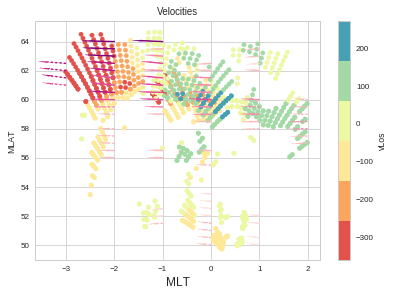

In [10]:
#### Plot the fitted SAPS velocities ####
#### Plot the fitted SAPS velocities ####
#### Plot the fitted SAPS velocities ####
# Seaborn styling
sns.set_style("whitegrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("RdPu"))
vLosSeaMap = ListedColormap(sns.color_palette("Spectral"))
# Plot using matplotlib
fig1 = plt.figure()
ax = fig1.add_subplot(111)

# fitResultsDF.plot( kind='scatter',
#               x='normMlt',
#               y='mlat',
#               c='velSAPS',
#               s=1., cmap=seaMap, ax=ax)
velsDataDF.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vLos',
              s=20., cmap=vLosSeaMap, ax=ax)
ax.set_ylabel("MLAT")
ax.set_xlabel("MLT", fontsize=12)
ax.set_title( "Velocities" )
# Overlay the SAPS vel vectors
velScaleMin = 0.
# round off max velocity to the next hundred
velScaleMax = (fitResultsDF["velSAPS"].max() + 100.)*100/100 -\
            (fitResultsDF["velSAPS"].max() + 100.)%100
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for frRows in fitResultsDF.iterrows():
    # Plot Velocity vectors
    currCol = seaMap( colNorm(frRows[1]["velSAPS"]) )
    if frRows[1]["goodFit"]:
        
        ax.plot( [ frRows[1]["normMlt"] , frRows[1]["endPtNormMLT"] ],\
                [ frRows[1]["mlat"], frRows[1]["endPtMLAT"] ], color=currCol ) 
        ax.arrow( frRows[1]["normMlt"], frRows[1]["mlat"], \
                 frRows[1]["endPtNormMLT"]-frRows[1]["normMlt"],\
                 frRows[1]["endPtMLAT"]-frRows[1]["mlat"],\
                     head_width=0.1, head_length=0.2, fc=currCol, ec=currCol)
    else:
        ax.plot( [ frRows[1]["normMlt"] , frRows[1]["endPtNormMLT"] ],\
                [ frRows[1]["mlat"], frRows[1]["endPtMLAT"] ], color=currCol, linestyle='dotted') 
        ax.arrow( frRows[1]["normMlt"], frRows[1]["mlat"], \
                 frRows[1]["endPtNormMLT"]-frRows[1]["normMlt"],\
                 frRows[1]["endPtMLAT"]-frRows[1]["mlat"],\
                     head_width=0.1, head_length=0.2, fc=currCol, ec=currCol, linestyle='dotted')
    
fig1.savefig("../figs/allFitVels-apr9-test.pdf",bbox_inches='tight')

In [11]:
print fitResultsDF

     azimSAPS    azimSTD  delMLT goodFit  mlat  normMlt     velSAPS  \
0    2.322779   1.499245     1.0    True  59.0      0.0  176.989306   
1   -6.783883   1.483354     1.0    True  56.0     -1.0  114.135680   
2   -3.426777   2.083208     1.5    True  56.0     -2.0  110.717489   
3   -8.213906   1.721974     1.5    True  64.0     -1.0  434.911132   
4   10.373121   2.196265     0.5    True  52.0     -1.0   51.637878   
5   -4.327350   2.056830     0.5    True  56.5      0.0  102.496933   
6   -8.791649   1.050444     1.0    True  60.0      0.0  273.564534   
7   -7.669407   2.990777     1.0    True  59.5     -1.0  185.201681   
8   -8.808500   1.299089     1.0    True  63.0     -2.0  417.576639   
9  -10.058659   4.530905     1.5    True  62.0      0.0  128.169053   
10  -6.152047   0.972861     0.5    True  60.5     -1.0  312.029865   
11  -3.637156   1.822166     1.5    True  60.0     -2.0  285.884840   
12  -6.256410   1.179399     1.5    True  56.5     -2.0  121.218431   
13 -16

NameError: name 'mltMlatMeanDF' is not defined

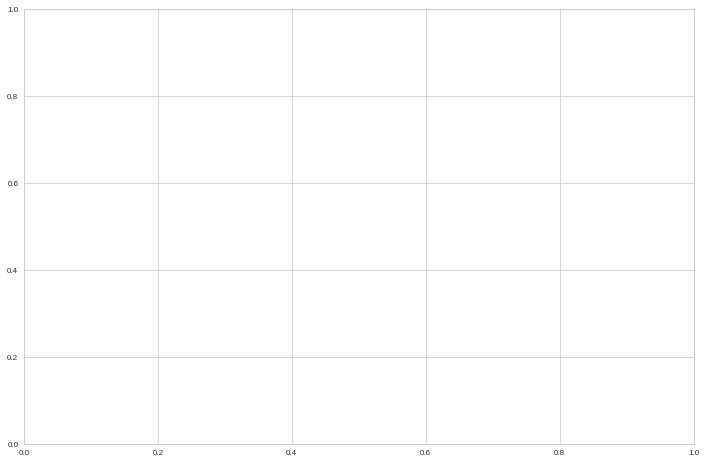

In [12]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

# Not only velocity magnitudes we'd also 
# like to plot azimuths!
# get the end points of vectors
mltMlatMeanDF["plot_MLATEnd"] = numpy.round( (mltMlatMeanDF["vSaps"]/1000.) *\
                                numpy.cos( numpy.deg2rad(-90-1*mltMlatMeanDF["azim"]) ) +\
                                mltMlatMeanDF["MLAT"], 2)
mltMlatMeanDF["plot_normMLTEnd"] = numpy.round( (mltMlatMeanDF["vSaps"]/1000.) *\
                                numpy.sin( numpy.deg2rad(-90-1*mltMlatMeanDF["azim"]) ) +\
                                mltMlatMeanDF["normMLT"], 2)

# Now setup a velocity scale
velScaleMin = 0.
# round off max velocity to the next hundred
velScaleMax = (mltMlatMeanDF["vSaps"].max() + 100.)*100/100\
    - (mltMlatMeanDF["vSaps"].max() + 100.)%100

# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))

mltMlatMeanDF.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax)
ax.set_xlabel("MLT", fontsize=14)
ax.set_ylabel("Latitude", fontsize=14)
ax.set_title( "SAPS Velcoties", fontsize=14 )



plotMLTends = mltMlatMeanDF['plot_normMLTEnd'].tolist()
plotMLATends = mltMlatMeanDF['plot_MLATEnd'].tolist()
plotMLTbegins = mltMlatMeanDF['normMLT'].tolist()
plotMLATbegins = mltMlatMeanDF['MLAT'].tolist()
plotVelMagns = mltMlatMeanDF['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        
plt.savefig("../figs/mltMlatVelVecs.pdf",bbox_inches='tight')